## Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Loading and Preprocessing Image Data

In [2]:
dataset_path = "datasets/Brain Tumor"

def load_images(folder):
    images = []
    file_names = []

    for file_name in os.listdir(folder):
        img_path = os.path.join(folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (150,150))
        images.append(img)
        file_names.append(file_name)

    return np.array(images), file_names

In [3]:
# Load images
images, file_names = load_images(dataset_path)

# Normalize pixel values (0-1)
images = images/255.0

# Clustering
images_flattened = images.reshape(len(images), -1)

print(f'Loaded {len(images)} images\nshape: {images.shape}')

Loaded 3762 images
shape: (3762, 150, 150)


## Dimensionality Reduction using PCA

In [4]:
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images_flattened)

print(f'Transformed shape: {images_pca.shape}')

Transformed shape: (3762, 50)


## Feature Extraction using VGG16 (CNN)

In [5]:
model_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
model = Model(inputs=model_base.input, outputs=model_base.layers[-1].output)

def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150,150))
    img = np.expand_dims(img, axis=0)   # Batch dimension
    img = img / 255.0   # Normalize pixel value
    features = model.predict(img)

    return features.flatten()

In [6]:
cnn_features = np.array([extract_features(os.path.join(dataset_path, f)) for f in file_names])

print(f'\nExtracted CNN features shape: {cnn_features.shape}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

## Building Autoencoder (Convolutional)

In [7]:
input_shape = (150,150,1)
input_img = Input(shape=input_shape)

# Encoder
x = Conv2D(32,(3,3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(16,(3,3), activation='relu', padding='same')(x) 
x = Conv2DTranspose(16,(2,2), strides=(2,2), padding='same')(x)
x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(x)
decoded = Conv2D(1,(3,3), activation='sigmoid', padding='same')(x)
decoded = Cropping2D(((1, 1), (1, 1)))(decoded)

# Compile
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 76, 76, 16)     │         1,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 76, 76, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 152, 152, 32)   │         4,128 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 152, 152, 1)    │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 150, 150, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,361 (67.82 KB)

 Trainable params: 17,361 (67.82 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Reshape images for autoencoder
images_reshaped = images.reshape(-1, 150, 150, 1)

# Train
autoencoder.fit(images_reshaped, images_reshaped, epochs=25, batch_size=16, validation_split=0.1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - loss: 0.0891 - val_loss: 0.0020
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 177ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - loss: 0.0011 - val_loss: 9.0965e-04
Epoch 8/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - loss: 0.0010 - val_loss: 8.4507e-04
Epoch 9/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - loss: 9.5545e-04 - val_loss: 8.0832e-04
Epoch 10/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - loss: 8.9831e-04 - val_loss: 7.5948e-04
Epoch 11/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - loss: 8.5479e-04 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


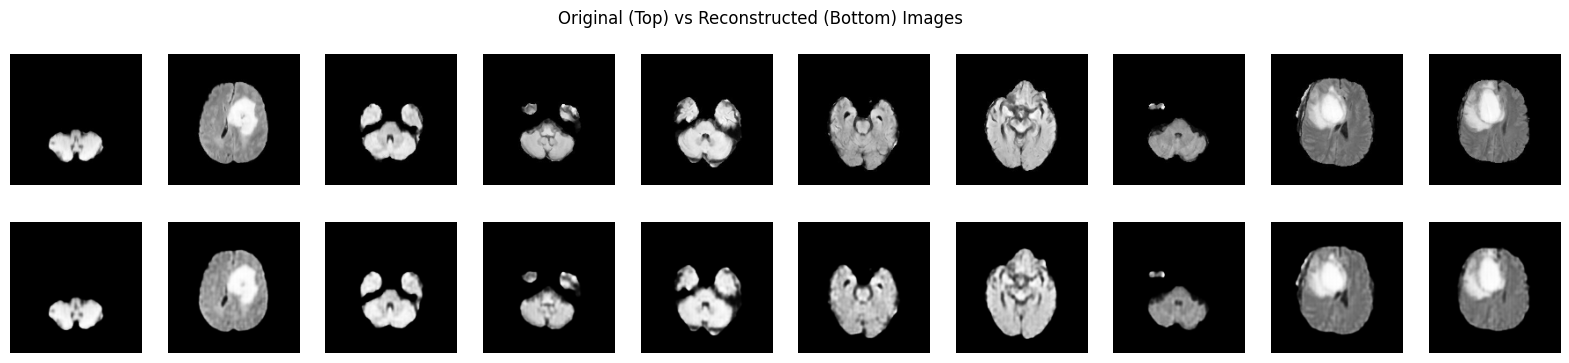

In [9]:
# Reconstruction Visualization
reconstructed_images = autoencoder.predict(images_reshaped[:10])

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(images_reshaped[i].reshape(150, 150), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i].reshape(150, 150), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle("Original (Top) vs Reconstructed (Bottom) Images")
plt.show()